Solver takes in the following two arguments:

• a list of radii

• a dictionary describing the planet's composition

At each radii in the list, Solver will iteratively calculate the density and the pressure at that location.

It is recommended that the ```radii_list``` argument follow this form:
```
[*range(1, int(r_planet), int(r_planet / slices))]
```
where ```r_planet``` is the radius of the planet in kilometers and "slices" is the number of points to calculate within the planet.

The dictionary, otherwise known as ```insert_dict```, will be created using this form:
```
planetary_dictionary(planet_size, iron_part, rock_part)
```

• ```planet_size```: radius of planet in Earth-radii

• ```iron_part```: the fractional depth of the iron core

• ```rock_part```: the fractional depth of the rock mantle

Note that ```r_planet``` from the ```radii_list``` must match the ```planet_size``` (scaled by Earth radii) from the dictionary.

Solver will ultimately return two lists: 1) the densities corresponding to each radii and 2) the pressures corresponding to each radii.

Note that all computation is done in SI Units.

In [26]:
import EoS_Bits as EOS
import planetary_dictionary as dct
import solve_adams_williamson as aw


def Solver(radii_list, insert_dict, density_list = [], discrepancy = 10, calls = 0):
#The density list is initially empty and is populated after the first run.
#The discrepancy represents the error in density.


    pressure_n = {}
    pressure_n1 = {}
    density_n1 = {}
    calls += 1


    while calls <= 1500:
    #Prevents the number of recursions from diverging.
        if int(max([*insert_dict.keys()])) != int(max(radii_list)):            
            insert_dict[int(float(f"{int(max(radii_list))}"))] = insert_dict.pop(int(float(f'{max([*insert_dict.keys()])}')))
            return(Solver(radii_list, insert_dict, density_list = [], discrepancy = discrepancy, calls = 0))
        #Ensures that the maximum radius in the planet's dictionary and the radius list are compatible

        
        if len(density_list) == 0:
            for count in range(len(radii_list)):
                for cutoff in [*insert_dict.keys()]:
                        if radii_list[count] <= cutoff:
                            if count == len(density_list):
                                density_list.append(int(insert_dict[cutoff][0]))
        #On the first iteration, the Solver makes a density_list using initial density guesses as preliminary values
    
        pressure_list = aw.adams_williamson(radii_list, density_list)
        #pressure_list is a list of initial pressures at each radius.
        
        for n in radii_list:
            pressure_n[n] = pressure_list[n][1]
        #At each radius in the list, a corresponding pressure is assigned. This is the nth pressure.
        
        for n in radii_list:
            nth_p_n = pressure_n[n]
            #This assigns the pressure at the nth radius calculated for the nth time.
            for cutoff in list(insert_dict.keys()):    
                if n <= cutoff: 
                #Here, we select the correct EoS and EoS parameters corresponding that layer's radius, pressure, and material.
                    
                    if list(insert_dict.keys()).index(cutoff) == 0:
                    #This "if block" is for calculations within the Core.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                    
                        density_n1[n] = EOS.CoreDensity(nth_p_n)
                        pressure_n1[n] = EOS.Vinet(density_n1[n],7678,136.2 * (10 ** 9),5.97)
                        break
                        
                    elif list(insert_dict.keys()).index(cutoff) == 1:
                    #This "if block" is for calculations within the Mantle.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                        
                        density_n1[n] = EOS.RockDensity(nth_p_n)
                        
                        #Depending on the pressure, different EOS parameters are selected.
                        if nth_p_n < 2.5 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],2648,37.4 * (10 ** 9),6.2)
                            break
                        elif nth_p_n < 8 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],2921,96 * (10 ** 9),8.4)
                            break
                        elif nth_p_n < 14 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 18 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n],3491,160 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 23 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n],3548,182 * (10 ** 9),4.2) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 120 * (10 ** 9):
                            pressure_n1[n] = EOS.BM3(density_n1[n], 4101,256 * (10 ** 9),4)
                            break
                        else:
                            pressure_n1[n] = EOS.Vinet(density_n1[n], 4058,221 * (10 ** 9),4.2)
                            break
                        
                    elif list(insert_dict.keys()).index(cutoff) == 2:
                    #This "if block" is for calculations within the Ice.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                        density_n1[n] = EOS.IceDensity(nth_p_n)
                        
                        if nth_p_n < 1 * (10 ** 9):
                            pressure_n1[n] = EOS.Murnaghan(density_n1[n], 930, 9.85 * (10 ** 9), 6.6)
                            break
                        elif nth_p_n < 2.1 * (10 ** 9):
                            pressure_n1[n] = EOS.BM3(density_n1[n], 1271, 14.05 * (10 ** 9), 4)
                            break
                        else:
                            pressure_n1[n] = EOS.BM3(density_n1[n], 1456, 14.9 * (10 ** 9), 5.4)
                            break
    
        if all(abs(np.array(list(density_n1.values())[:1000]) - np.array(density_list[:1000]) < discrepancy)):
            return(list(density_n1.values()), list(pressure_n1.values()))
        #If all densities are self-consistent to 10 kg/m^3, return a list of densities and a list of pressures.
    
        else:
            return(Solver(radii_list, insert_dict, density_list = list(density_n1.values()), discrepancy = discrepancy, calls = calls))
        #If densities are not yet self-consistent, reiterate the process.
        
    return([0], [0])
    #If densities do not converge, then return empty lists.

Let's try creating a planet using ```planetary_dictionary``` and running our Solver to print out our densities and pressures.

Let's construct a planet that has a radius of 1 Earth radius. It will be 0.3 parts core and 0.5 parts mantle by depth.

In [27]:
print('Our dictionary:')
print(dct.planetary_dictionary(1, 0.3, 0.5))
print('\n')

print('Our densities and pressures:')
print(Solver([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.5)))

Our dictionary:
{1911000: [7678], 5096000: [3000], 6370000: [930]}


Our densities and pressures:
([11459.216836066436, 11459.158399554268, 11459.085351273214, 11458.994446298126, 11458.884872828989, 11458.75630571579, 11458.608581961154, 11458.441607995188, 11458.255324901958, 11458.049692964483, 11457.824683934858, 11457.580276820747, 11457.316455424469, 11457.033206830678, 11456.730520433266, 11456.408387286276, 11456.066799658864, 11455.705750719342, 11455.32523430797, 11454.925244769769, 11454.5057768293, 11454.066825492933, 11453.608385976571, 11453.1304536469, 11452.633023975719, 11452.116092502049, 11451.579654804525, 11451.02370647449, 11450.448243098264, 11449.853260238866, 11449.23875342355, 11448.60471813109, 11447.951149782166, 11447.278043731923, 11446.585395260863, 11445.873199570737, 11445.141451777126, 11444.390146906564, 11443.619279891234, 11442.82884556563, 11442.018838663425, 11441.189253815075, 11440.340085543972, 11439.471328265736, 11438.582976285074, 11437.6750

The dictionary has three keys. Each key represents the boundary at which materials change. In other words, our core has a radius of Key 1 meters. Our mantle begins at the edge of our core and extends to Key 2 meters. Our ice layer begins at the edge of the mantle and extends to Key 3 meters.

Our list of densities and pressures both start at the innermost radius and end with the outermost radius specified in our ```radii_list```.

Now, let's plot our density and/or pressure as a function of radius.

In [28]:
import matplotlib.pyplot as plt

def plotter(radii_list, insert_dict, density_or_pressure):
    if density_or_pressure.lower() == "density":
        to_plot = Solver(radii_list, insert_dict)[0]
    elif density_or_pressure.lower() == "pressure":
        to_plot = Solver(radii_list, insert_dict)[1]
    plt.plot(radii_list, to_plot)
    plt.show()

Call the ```plotter``` function with three arguments.

The first argument is our list of radii. In the following example, our list of radii runs from ```1``` to ```1 * 6.371 * (10 ** 6)``` in increments of ```6371``` (a thousand slices for an Earth-sized planet).

The second argument specifies the planet's profile. We use a planetary dictionary here.

The third argument is a string specifying either ```'density'``` or ```'pressure'``` to be plotted.

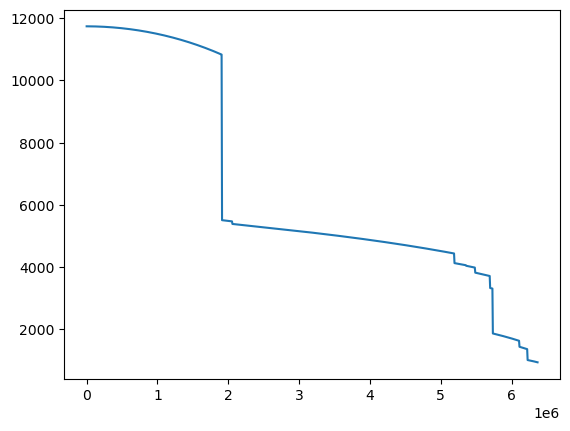

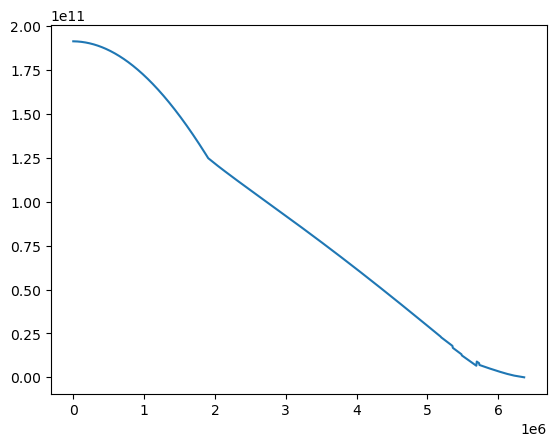

In [29]:
plotter([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.6), 'density')
plotter([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.6), 'pressure')